In [3]:
import pandas as pd
import numpy as np
import math
import quandl
import datetime
import pickle

# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


from sklearn import preprocessing, cross_validation, svm, model_selection
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Time Series Prediction with Machine Learning

Take continous data a try to find a line for given feature vector $X$ and output vector $y$, also called label.

## Prepare data set

In [50]:
df = quandl.get('WIKI/GOOGL')

In [51]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [52]:
# building own features, hopefully with more descriptive power
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] *100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] *100

In [53]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [54]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0
2004-08-20,54.322689,8.537313,7.227007,22834300.0
2004-08-23,54.869377,4.062357,-1.227880,18256100.0
2004-08-24,52.597363,7.753210,-5.726357,15247300.0
2004-08-25,53.164113,3.966115,1.183658,9188600.0


In [55]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

#forecast_out = int(math.ceil(0.001 * len(df)))

# shift data forward to create y
#df['label'] = df[forecast_col].shift(-forecast_out)
df['label'] = df[forecast_col].shift(-1)
df.dropna()
df.to_csv('./data/google.csv', sep=';')

In [56]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,54.322689
2004-08-20,54.322689,8.537313,7.227007,22834300.0,54.869377
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,52.597363
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,53.164113
2004-08-25,53.164113,3.966115,1.183658,9188600.0,54.122070


In [57]:
df = pd.read_csv('./data/google.csv', sep=';', header=0, parse_dates=True, index_col=0)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-1]

y = np.array(df['label'])
y=df['label']
y.dropna(inplace=True)
y=np.array(y)

df.dropna()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,54.322689
2004-08-20,54.322689,8.537313,7.227007,22834300.0,54.869377
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,52.597363
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,53.164113
2004-08-25,53.164113,3.966115,1.183658,9188600.0,54.122070
2004-08-26,54.122070,3.143512,2.820391,7094800.0,53.239345
2004-08-27,53.239345,2.772258,-1.803885,6211700.0,51.162935
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,51.343492
2004-08-31,51.343492,1.517228,0.048866,4917800.0,50.280210


Use train_trest_split or by hand slicing? Discussion: Does it make sense to create a random sample from the data?

In [58]:
len(X)

3296

In [59]:
# create random samples
# BAD
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [60]:
# slice up the actual time series
X_train = X[:3000, :]
y_train = y[:3000]

X_test = X[3000:, :]
y_test = y[3000:]


In [61]:
X_train

array([[-1.46766591,  4.2912458 ,  0.23172676,  4.4024535 ],
       [-1.45006096,  4.35714323,  4.79784957,  1.77778643],
       [-1.44765476,  1.2948448 , -0.79557722,  1.22720608],
       ..., 
       [ 1.54864922, -0.89266787, -0.46269029, -0.77382346],
       [ 1.62598193,  0.24559171,  1.38754122, -0.73560285],
       [ 1.62690623, -0.74445552,  0.32905191, -0.7852834 ]])

In [62]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

In [63]:
y_train.reshape(-1,1)

array([[  54.32268894],
       [  54.86937651],
       [  52.59736302],
       ..., 
       [ 753.2       ],
       [ 753.41      ],
       [ 757.08      ]])

In [64]:
X_train.reshape(-1, 4)

array([[-1.46766591,  4.2912458 ,  0.23172676,  4.4024535 ],
       [-1.45006096,  4.35714323,  4.79784957,  1.77778643],
       [-1.44765476,  1.2948448 , -0.79557722,  1.22720608],
       ..., 
       [ 1.54864922, -0.89266787, -0.46269029, -0.77382346],
       [ 1.62598193,  0.24559171,  1.38754122, -0.73560285],
       [ 1.62690623, -0.74445552,  0.32905191, -0.7852834 ]])

## OLS Regression

The the most known supervised learning alogorithm is <strong>ordinary least squares (OLS) regression</strong> method. OLS aims to  minimizing the sum of the squares of the differences between the observed responses (values of the variable being predicted) in the given dataset and those predicted by a linear function of a set of explanatory variables. - <a href="https://en.wikipedia.org/wiki/Ordinary_least_squares">Wikipedia</a>

The linear regression model

$$
y_i = \beta_1 + x_{i1} + \dots + \beta_p x_{ip} + \varepsilon_i
$$

can be vectorized

$$
y_i =  x_{i}^T \beta  + \varepsilon_i
$$

rearranged for the error

$$
\varepsilon_i = y_i -  x_{i}^T \beta
$$

squared

$$
\varepsilon_i^2 = \left( y_i -  x_{i}^T \beta \right)^2
$$

and summed over all $i = 1, \dots, n$

$$
\sum_{i=1}^n \varepsilon_i^2 = \sum_{i=1}^n \left( y_i -  x_{i}^T \beta \right)^2
$$

OLS regression can be performed using the <code>numpy</code> module

In [65]:
clf = LinearRegression(n_jobs=-1)

In [66]:
clf.fit(X_train, y_train.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [67]:
accuracy = clf.score(X_test, y_test)
accuracy

0.98587920224848991

In [68]:
y_hat = clf.predict(X_test)

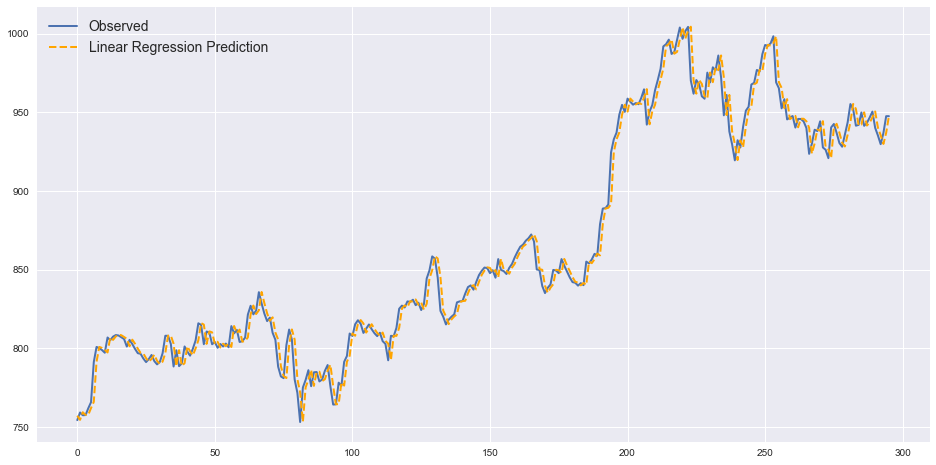

In [69]:
plt.plot(y_test, label='Observed')
plt.plot(y_hat, color='orange', linestyle='--', label='Linear Regression Prediction')
plt.legend(loc='upper left')
plt.show()

## Support Vector Regression

In [70]:
#rgr_lin = LogisticRegression().fit(X_train, y_train.reshape(-1, 1))
svr_lin = SVR(kernel='linear', C=1e3).fit(X_train, y_train.reshape(-1, 1))
svr_poly = SVR(kernel='poly', C=1e3).fit(X_train, y_train.reshape(-1, 1))
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1).fit(X_train, y_train.reshape(-1, 1))

C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
y_hat_svr_lin = svr_lin.predict(X_test)
y_hat_svr_poly = svr_poly.predict(X_test)
y_hat_svr_rbf = svr_rbf.predict(X_test)


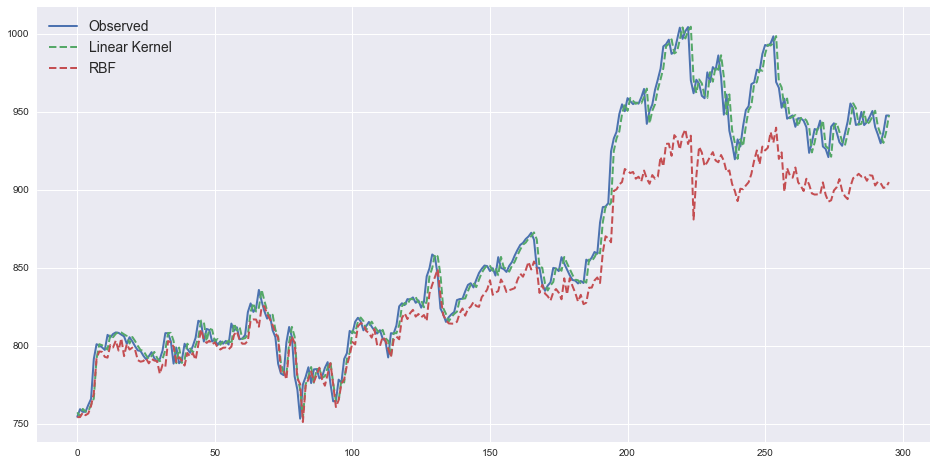

In [75]:
plt.plot(y_test, label='Observed');
plt.plot(y_hat_svr_lin, linestyle='--', label='Linear Kernel');
#plt.plot(y_hat_svr_poly, linestyle='--', label='Plynomial Kernel')
plt.plot(y_hat_svr_rbf, linestyle='--', label='RBF');
plt.legend(loc='upper left');
plt.show()

## Random Forest Regression



In [85]:
regr_rf = RandomForestRegressor(n_estimators=50,
                                max_features=3,
                                max_depth=40,
                                ).fit(X_train, y_train.reshape(-1, 1).ravel())

In [86]:
y_hat_regr_rf = regr_rf.predict(X_test)

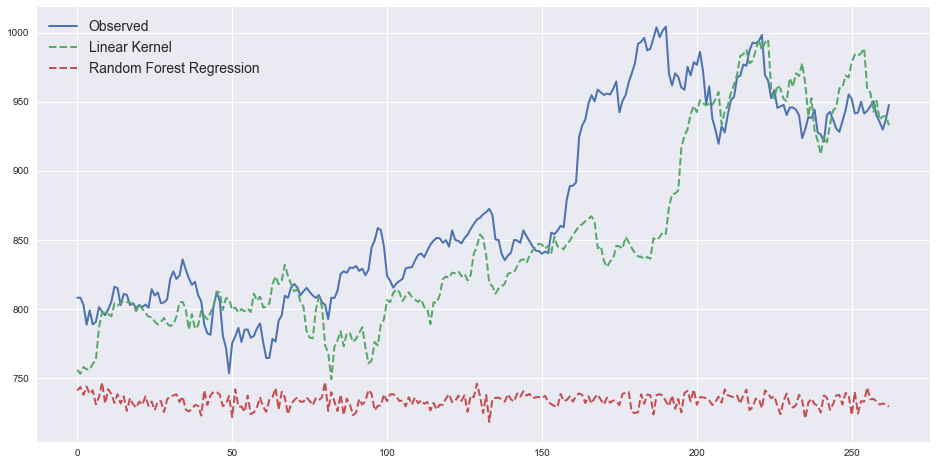

In [87]:
plt.plot(y_test, label='Observed');
plt.plot(y_hat_svr_lin, linestyle='--', label='Linear Kernel');
plt.plot(y_hat_regr_rf, linestyle='--', label='Random Forest Regression');
plt.legend(loc='upper left');
plt.show()

## Out of sample forecast

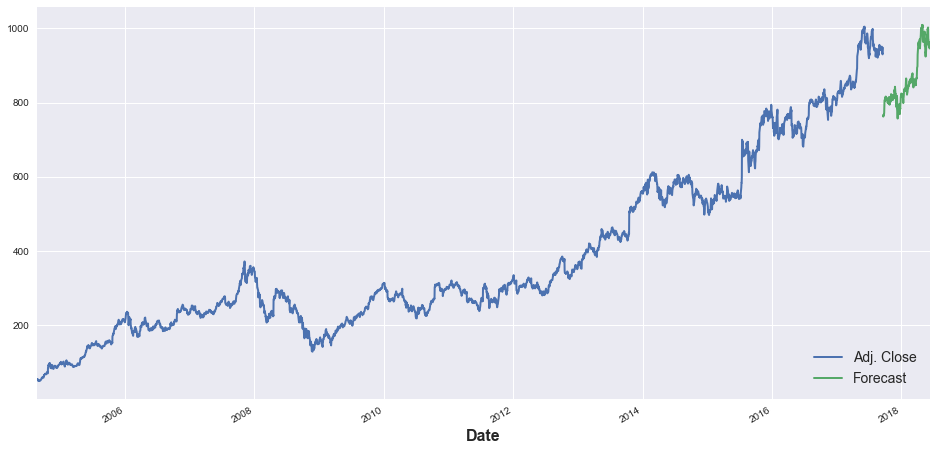

In [22]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].astype(float).plot()
plt.legend(loc=4)
plt.show()